### Purpose
This notebook trims images according to the seam carving algorithm to remove dead space. The procedure works as follows:
   1. Take an image and find edges (using a Sobel filter convolution)
   2. Calculate paths (seams) through the image which go through a minimal number of edges
   3. Remove seams from the image in increasing order of total amount of edges passed through

### Still needed
-Framework should be converted into a .py file and be callable (play with classes)

-Currently only works for horizontal scaling

-Would be cool to create an animation that shows it working

-Would like to be able to select pixels that must be kept or must be removed. How to do this interface? GUI?


In [1]:
__author__="Matt Gomer"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
mpl.rc('image', cmap='gray')
import scipy
from scipy import signal
from scipy import fftpack
from PIL import Image
import time
import copy
import sys

In [1]:
source_image=mpimg.imread('image_processing/images/goose.jpg')
# source_image=source_image[200:1400,:]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(source_image)
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


#need edge detection to calculate energy
#is there a difference between sobel fiter and high pass filter?
def high_pass_fft_filter(img,filter_rad):
    img_height=np.shape(img)[0]
    print(img_height)
    img_width=np.shape(img)[1]
    F = fftpack.fftshift( fftpack.fft2(img))
    x_range=np.arange(0,img_width)
    y_range=np.arange(0,img_height)
    x_grid,y_grid=np.meshgrid(x_range,y_range)
    x_shift = x_grid - int(img_width/2)
    y_shift = y_grid - int(img_height/2)
    R = np.sqrt(x_shift*x_shift + y_shift*y_shift)
    mask = np.empty_like(R)
    mask[R > filter_rad] = 1
    mask[R <= filter_rad] = 0
    filt_fft=mask*F
    filtered_img = fftpack.ifft2(filt_fft)
    if np.all(np.imag(filtered_img)<10**-9):
        filtered_img=np.abs(filtered_img)
    else:
        print('Error: problem with fft: output is complex')
    return filtered_img

def low_pass_fft_filter(img,filter_rad):
    img_height=np.shape(img)[0]
    img_width=np.shape(img)[1]
    F = fftpack.fftshift( fftpack.fft2(img))
    x_range=np.arange(0,img_width)
    y_range=np.arange(0,img_height)
    x_grid,y_grid=np.meshgrid(x_range,y_range)
    x_shift = x_grid - int(img_width/2)
    y_shift = y_grid - int(img_height/2)
    R = np.sqrt(x_shift*x_shift + y_shift*y_shift)
    mask = np.empty_like(R)
    mask[R <= filter_rad] = 1
    mask[R > filter_rad] = 0
    filt_fft=mask*F
    filtered_img = fftpack.ifft2(filt_fft)
    if np.all(np.imag(filtered_img)<10**-9):
        filtered_img=np.abs(filtered_img)
    else:
        print('Error: problem with fft: output is complex')
    return filtered_img

fig, ax = plt.subplots(figsize=(10, 10))
low_passed_img=low_pass_fft_filter(rgb2gray(source_image),150)
ax.imshow(low_passed_img)
#sobel filter

def partial_derivatives(grayimg, grad_x=True, grad_y=True):
    Gx,Gy=np.zeros_like(grayimg),np.zeros_like(grayimg)
    Sx=np.array([[-0.125, 0, 0.125],
    [-0.25, 0, 0.25],
    [-0.125, 0, 0.125]])
    Sy=np.array([[-0.125, -0.25, -0.125],
    [0, 0, 0],
    [0.125, 0.25, 0.125]])
    if grad_x:
        Gx=signal.convolve2d(grayimg,Sx,mode='same')
    if grad_y:
        Gy=signal.convolve2d(grayimg,Sy,mode='same')
    return(Gx,Gy)

Gx,Gy=partial_derivatives(rgb2gray(source_image))
grad=np.sqrt(Gx**2+Gy**2)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(grad)

Gx,Gy=partial_derivatives(low_passed_img)
grad=np.sqrt(Gx**2+Gy**2)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(grad)


#future exploration: what is a Scharr kernel? How can it be complex?
    
#need way to sum up minimal energy

#need function to trim off pixels

#need animation with slider to trim



NameError: name 'mpimg' is not defined

0.4787865519523621


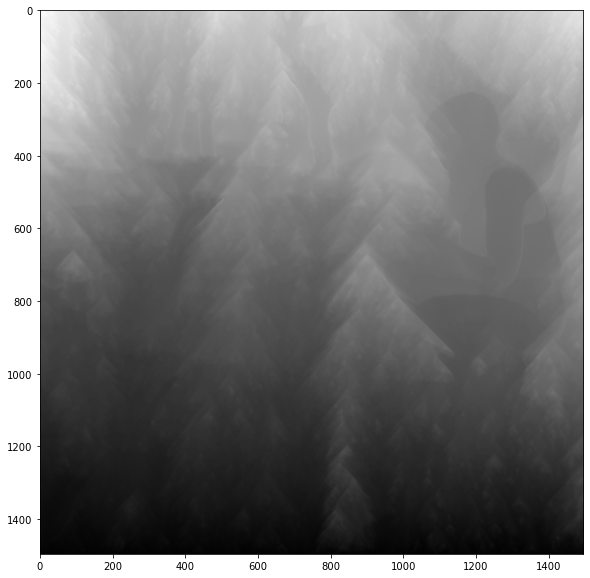

In [3]:
def findCostArr(edgeImg): #this faster vectorized version of the slow function I made found here: https://www.analyticsvidhya.com/blog/2020/09/seam-carving-algorithm-a-seemingly-impossible-way-to-resize-an-image/
    r,c = edgeImg.shape
    cost = np.zeros(edgeImg.shape)
    cost[r-1,:] = edgeImg[r-1,:] #set bottom row equal to edge bottom row
    for i in range(r-2,-1,-1): #loop from penultimate row to top row
        for j in range(c):
            c1,c2 = max(j-1,0),min(c,j+2) #identify relevant range of pixel i
            cost[i][j] = edgeImg[i][j] + cost[i+1,c1:c2].min() #add min to current value
    return cost

#there is a difference between the two functions in that one adds 1 at each column (shouldn't affect result)
def energ(grad,shrink_axis='x'): #This is my function. this is slow.
    energ=np.zeros_like(grad)
    r,c = grad.shape
    row_from_bottom=0
    for row_from_bottom in np.arange(r):
        if row_from_bottom==0:
            current_row=grad[-1-row_from_bottom,:]
            energ[-1-row_from_bottom,:]=current_row
            continue
        previous_row=energ[-row_from_bottom,:]
        current_row=grad[-1-row_from_bottom,:]

        for ix, value in enumerate(current_row-1):
            if ix==0:
                energ[-1-row_from_bottom,ix]=np.minimum(previous_row[0],previous_row[1])+value
            elif ix==len(current_row)-1:
                energ[-1-row_from_bottom,ix]=np.minimum(previous_row[-1],previous_row[-2])+value
            else:
#                 print(np.min([previous_row[ix-1],previous_row[ix],previous_row[ix+1]]))
                energ[-1-row_from_bottom,ix]=np.min([previous_row[ix-1],previous_row[ix],previous_row[ix+1]])+value
    return energ
                
        #for each pixel, check 3 from row below, add minimum
# starttime=time.time()
# energy_arr=energ(grad)
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(energy_arr)
# print((time.time()-starttime)/60)

starttime=time.time()
cost_array=findCostArr(grad)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cost_array)
print((time.time()-starttime)/60)



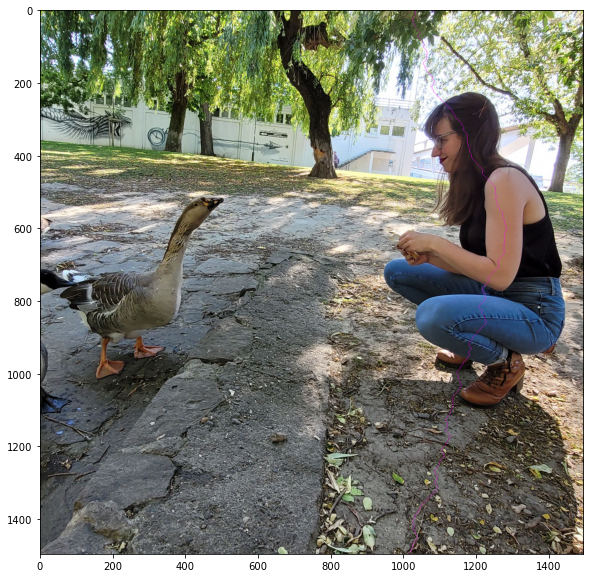

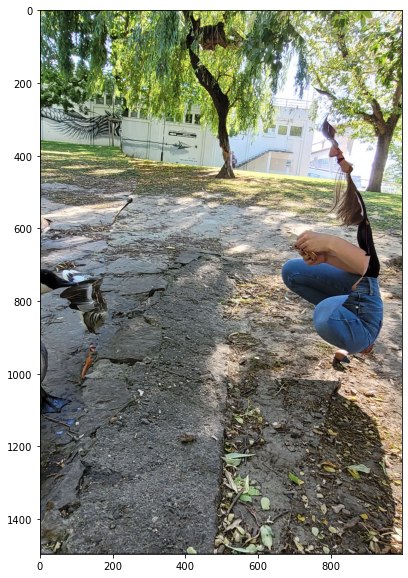

In [4]:
def find_min_path(cost_array):
    r,c=cost_array.shape
    path_indices=[]
    way=cost_array[0].argmin()
    path_indices.append(way)
    for row in range(1,r-1):
        c1,c2 = max(way-1,0),min(c,way+2) #identify relevant range of pixel i
        way=cost_array[row][c1:c2].argmin()+c1
        path_indices.append(way)
    return(path_indices)


def show_next_seam_image(image,path_indicies,seam_color=[255,0,255]):
    seam=copy.copy(image)
    for row,path in enumerate(path_indicies):
        seam[row,path,:]=seam_color
    return(seam)

def remove_seam(image,path_indicies):
    if len(image.shape)==3:
        r,c,colordim=image.shape
        new_image=np.zeros_like(image)
        for row,path in enumerate(path_indicies):
            new_image[row,:path]=image[row,:path]
            new_image[row,path:c-1]=image[row,path+1:c]
        return new_image[:,:-1,:]
    else:
        r,c=image.shape
        new_image=np.zeros_like(image)
        for row,path in enumerate(path_indicies):
            new_image[row,:path]=image[row,:path]
            new_image[row,path:c-1]=image[row,path+1:c]
        return new_image[:,:-1]


fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(show_next_seam_image(source_image,find_min_path(cost_array)))
plt.show()
cut_image=remove_seam(source_image,find_min_path(cost_array))
cut_cost_array=remove_seam(cost_array,find_min_path(cost_array))
for i in range(1,500):
    next_path=find_min_path(cut_cost_array)
    cut_image=remove_seam(cut_image,next_path)
    cut_cost_array=remove_seam(cut_cost_array,next_path)
    
    
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cut_image)


# print(np.shape(next_seam_array(cost_array)))

Finding edges...
Calculating paths...
Carving...
Done! Time elapsed: 52.6 seconds


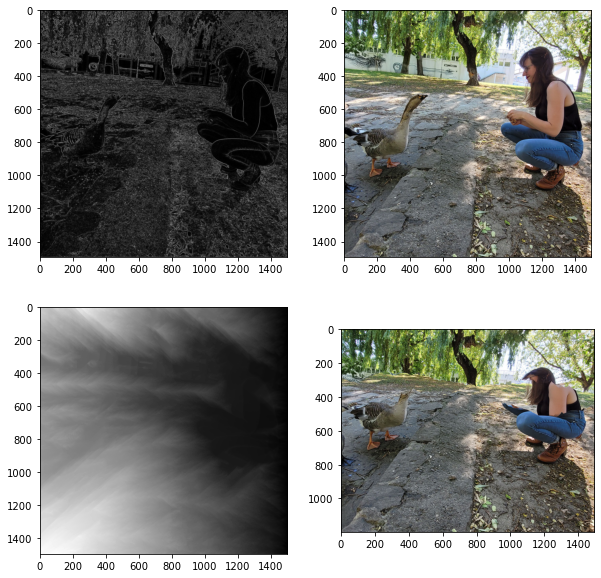

Finding edges...
Calculating paths...
Carving...
Done! Time elapsed: 54.8 seconds


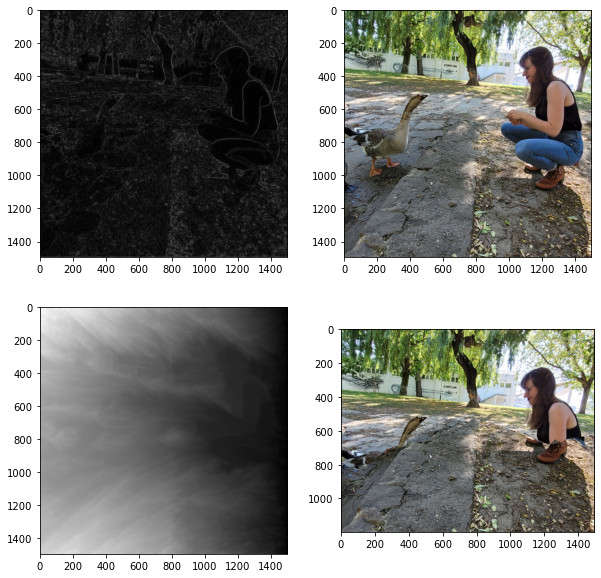

Finding edges...
Calculating paths...
Carving...
Done! Time elapsed: 53.9 seconds


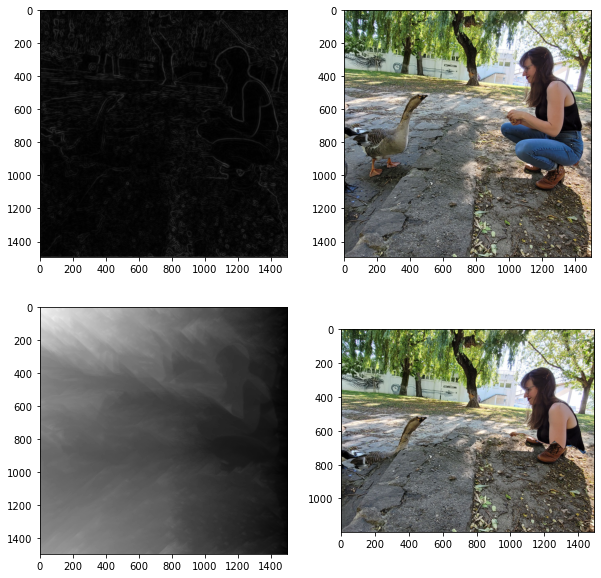

Finding edges...
Calculating paths...
Carving...
Done! Time elapsed: 55.6 seconds


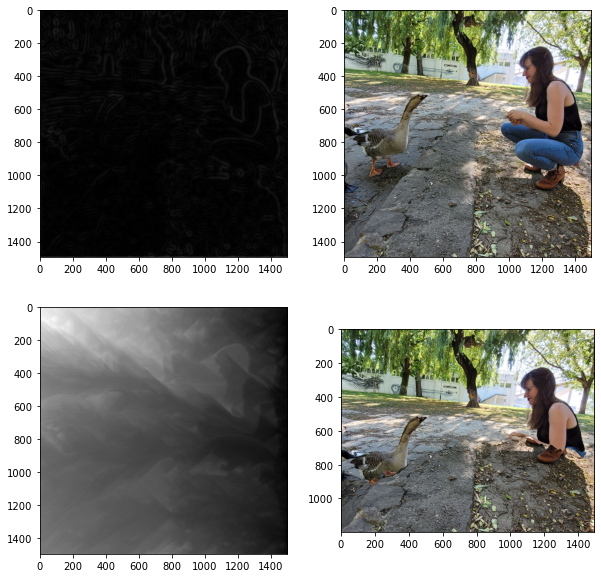

In [23]:
def seam_carve(source_image, npix, trim='horizontal',blur=None):
#    Complete procedure from above cells combined together in one function.
#    Inputs
#      -source_image: RGB image as np array
#      -npix: integer number of pixels desired to shorten the width of the image
#      -trim: string 'horizontal' or 'vertical' indicating direction of shrinking desired
#      -blur: default None, integer number for low pass filter cutoff applied before carving if desired
#
    start_time=time.time()
    if trim != 'horizontal' and trim != 'vertical':
        sys.exit('Error: not compatible with trim option')
    if trim == 'vertical':
        source_image=source_image.swapaxes(0,1)
    if blur !=None:
        low_passed_img=low_pass_fft_filter(rgb2gray(source_image),blur)
    else:
        low_passed_img=rgb2gray(source_image)
    print('Finding edges...')
    Gx,Gy=partial_derivatives(low_passed_img)
    grad=np.sqrt(Gx**2+Gy**2)
    print('Calculating paths...')
    cost_array=findCostArr(grad)
    print('Carving...')
    cut_image=remove_seam(source_image,find_min_path(cost_array))
    cut_cost_array=remove_seam(cost_array,find_min_path(cost_array))
    for i in range(1,npix):
        next_path=find_min_path(cut_cost_array)
        cut_image=remove_seam(cut_image,next_path)
        cut_cost_array=remove_seam(cut_cost_array,next_path)
    elapsed_time=time.time()-start_time

    fig, ax = plt.subplots(2,2,figsize=(10, 10))
    if trim=='vertical':
        source_image=source_image.swapaxes(0,1)
        cut_image=cut_image.swapaxes(0,1)
        grad=grad.swapaxes(0,1)
        cost_array=cost_array.swapaxes(0,1)
    ax[0,1].imshow(source_image)
    ax[0,0].imshow(grad)
    ax[1,0].imshow(cost_array)
    ax[1,1].imshow(cut_image)
    
    print('Done! Time elapsed: {:.1f} seconds'.format(elapsed_time) )
    return cut_image, fig, ax


source_image=np.array(mpimg.imread('images/goose.jpg'))
# cut_image, fig, ax=seam_carve(source_image,300)
# plt.show()
# cut_image, fig, ax=seam_carve(source_image,300,blur=200)
# plt.show()
# cut_image, fig, ax=seam_carve(source_image,300,blur=100)
# plt.show()
# cut_image, fig, ax=seam_carve(source_image,300,blur=50)
# plt.show()

cut_image, fig, ax=seam_carve(source_image,300,trim='vertical')
plt.show()
cut_image, fig, ax=seam_carve(source_image,300,trim='vertical',blur=200)
plt.show()
cut_image, fig, ax=seam_carve(source_image,300,trim='vertical',blur=100)
plt.show()
cut_image, fig, ax=seam_carve(source_image,300,trim='vertical',blur=50)
plt.show()


In [ ]:


fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(source_image)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cut_image)